### LychSim 3D Ground Truth Demo

In [1]:
import io

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from lychsim.api import Client

client = Client(('localhost', 9000))
client.connect()

print(client.request('vget /unrealcv/status'))

INFO:client:235:Got connection confirm: b'connected to MyProject7'


=>Info: using ip-port socket
Is Listening
Client Connected
9000
Configuration
Config file: C:/Program Files/Epic Games/UE_5.5/Engine/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 1920
Height: 1080
FOV: 90.000000
EnableInput: true
EnableRightEye: false



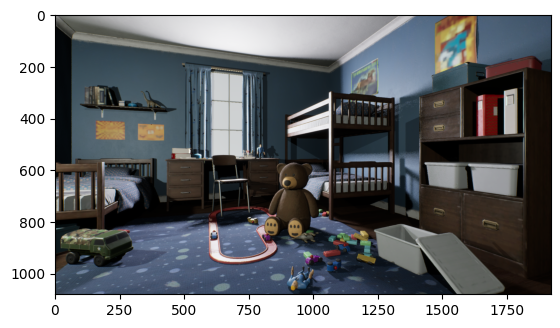

In [2]:
def get_rgba():
    res = client.request('vget /camera/1/lit png')
    return np.array(Image.open(io.BytesIO(res)))

img = get_rgba()
plt.imshow(img)
Image.fromarray(img).save('teddy.png')

In [3]:
def get_aabb(object_name):
    res = client.request(f'lych object get_aabb {object_name}')
    res = [float(x) for x in res.strip().split(' ')]
    return np.array(res[:3]), np.array(res[3:])

def get_corners(center, extent):
    corners = np.array([
        [-1, -1, -1],
        [1, -1, -1],
        [1, 1, -1],
        [-1, 1, -1],
        [-1, -1, 1],
        [1, -1, 1],
        [1, 1, 1],
        [-1, 1, 1],
    ])
    edges = np.array([
        [0, 1], [1, 2], [2, 3], [3, 0],
        [4, 5], [5, 6], [6, 7], [7, 4],
        [0, 4], [1, 5], [2, 6], [3, 7],
    ])
    corners = corners * extent
    corners = corners + center
    return corners, edges

object_name = 'SM_Toy_teddy_178'
center, extent = get_aabb(object_name)
corners, edges = get_corners(center, extent)
print('Center:', center)
print('Extent:', extent)
print('Corners:', corners)

Center: [ 132.579 1119.096   35.257]
Extent: [37.223 37.816 35.447]
Corners: [[ 9.535600e+01  1.081280e+03 -1.900000e-01]
 [ 1.698020e+02  1.081280e+03 -1.900000e-01]
 [ 1.698020e+02  1.156912e+03 -1.900000e-01]
 [ 9.535600e+01  1.156912e+03 -1.900000e-01]
 [ 9.535600e+01  1.081280e+03  7.070400e+01]
 [ 1.698020e+02  1.081280e+03  7.070400e+01]
 [ 1.698020e+02  1.156912e+03  7.070400e+01]
 [ 9.535600e+01  1.156912e+03  7.070400e+01]]


In [4]:
def get_c2w():
    res = client.request('lych cam get_c2w 1')
    res = [float(x) for x in res.strip().split(' ')]
    return np.array(res).reshape(4, 4)

c2w = get_c2w()
print('Camera to World:\n', c2w)

Camera to World:
 [[-9.33580e-01  3.58368e-01  0.00000e+00  3.80000e+02]
 [-3.58368e-01 -9.33580e-01  0.00000e+00  1.20000e+03]
 [ 0.00000e+00 -0.00000e+00  1.00000e+00  8.00000e+01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]


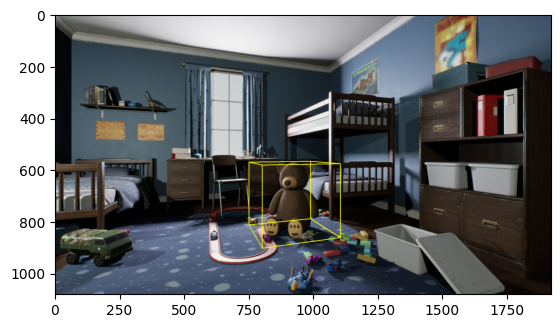

In [5]:
def get_fov():
    res = client.request('lych cam get_fov 1')
    return float(res.strip())

def fx_fy_from_fovx(fovx_deg, W, H):
    fovx = np.deg2rad(fovx_deg)
    fx = 0.5 * W / np.tan(0.5 * fovx)
    fovy = 2.0 * np.arctan((H / float(W)) * np.tan(0.5 * fovx))
    fy = 0.5 * H / np.tan(0.5 * fovy)
    return fx, fy

def project(corners, c2w, fov):
    w2c = np.linalg.inv(c2w)
    pts_h = np.concatenate([corners, np.ones((corners.shape[0], 1))], axis=1)
    pc = (w2c @ pts_h.T).T
    Xc, Yc, Zc = pc[:,0], pc[:,1], pc[:,2]

    in_front = Xc > 0

    fx, fy = fx_fy_from_fovx(fov, W, H)
    cx, cy = 0.5 * W, 0.5 * H

    u = fx * (Yc / Xc) + cx
    v = fy * (-Zc / Xc) + cy

    uv = np.stack([u, v], axis=-1).reshape(-1, 2)
    in_front = in_front.reshape(corners.shape[:-1])
    return uv, in_front

def visualize_bbox(img, corners_2d, edges, color=(255, 255, 0, 255), thickness=2):
    for i, j in edges:
        pt1 = (int(corners_2d[i, 0]), int(corners_2d[i, 1]))
        pt2 = (int(corners_2d[j, 0]), int(corners_2d[j, 1]))
        cv2.line(img, pt1, pt2, color, thickness)
    plt.imshow(img)
    return img

fov = get_fov()
H, W = img.shape[:2]
pts2d, _ = project(corners, c2w, fov)
vis_img = visualize_bbox(img.copy(), pts2d, edges)
Image.fromarray(vis_img).save('teddy_aabb.png')

Center: [ 132.579 1119.096   35.257]
Extent: [37.223 37.816 35.447]
Rotation: [ 0. 36.  0.]
Rotation matrix:
 [[ 0.80901699 -0.58778525  0.        ]
 [ 0.58778525  0.80901699  0.        ]
 [ 0.          0.          1.        ]]
(8, 3)


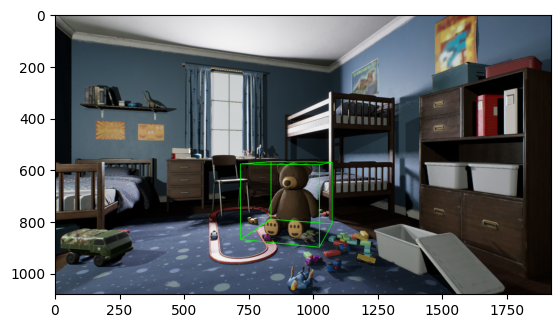

In [6]:
def get_obb(object_name):
    res = client.request(f'lych object get_obb {object_name}')
    res = [float(x) for x in res.strip().split(' ')]
    return np.array(res[:3]), np.array(res[3:6]), np.array(res[6:])

from scipy.spatial.transform import Rotation as R
def rot_mat2(rotation):
    r = R.from_euler('XZY', rotation, degrees=True)
    return r.as_matrix()

def rot_mat(rotation):
    pitch, yaw, roll = rotation
    # UE 默认应用顺序：Yaw(Z) -> Pitch(X) -> Roll(Y)
    p, y, r = np.radians([pitch, yaw, roll])
    Rz = np.array([[ np.cos(y), -np.sin(y), 0],
                   [ np.sin(y),  np.cos(y), 0],
                   [ 0,          0,         1]])
    Rx = np.array([[1, 0,          0        ],
                   [0, np.cos(p), -np.sin(p)],
                   [0, np.sin(p),  np.cos(p)]])
    Ry = np.array([[ np.cos(r), 0, np.sin(r)],
                   [ 0,         1, 0        ],
                   [-np.sin(r), 0, np.cos(r)]])
    return Rz @ Rx @ Ry

def get_corners(center, extent, rotation_matrix=None):
    corners = np.array([
        [-1, -1, -1],
        [1, -1, -1],
        [1, 1, -1],
        [-1, 1, -1],
        [-1, -1, 1],
        [1, -1, 1],
        [1, 1, 1],
        [-1, 1, 1],
    ])
    edges = np.array([
        [0, 1], [1, 2], [2, 3], [3, 0],
        [4, 5], [5, 6], [6, 7], [7, 4],
        [0, 4], [1, 5], [2, 6], [3, 7],
    ])
    corners = corners * extent
    if rotation_matrix is not None:
        corners = (rotation_matrix @ corners.T).T
    corners = corners + center
    return corners, edges

object_name = 'SM_Toy_teddy_178'
center, extent, rotation = get_obb(object_name)
rotation = np.array([rotation[0], rotation[1], rotation[2]])
mat = rot_mat2(rotation)
print('Center:', center)
print('Extent:', extent)
print('Rotation:', rotation)
print('Rotation matrix:\n', mat)

corners, edges = get_corners(center, extent, mat)
print(corners.shape)
pts2d, _ = project(corners, c2w, fov)
vis_img = visualize_bbox(img.copy(), pts2d, edges, color=(0, 255, 0, 255))
Image.fromarray(vis_img).save('teddy_obb.png')